In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

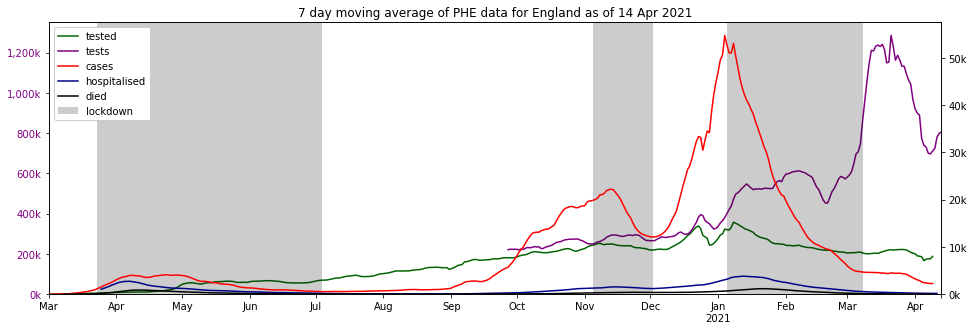

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

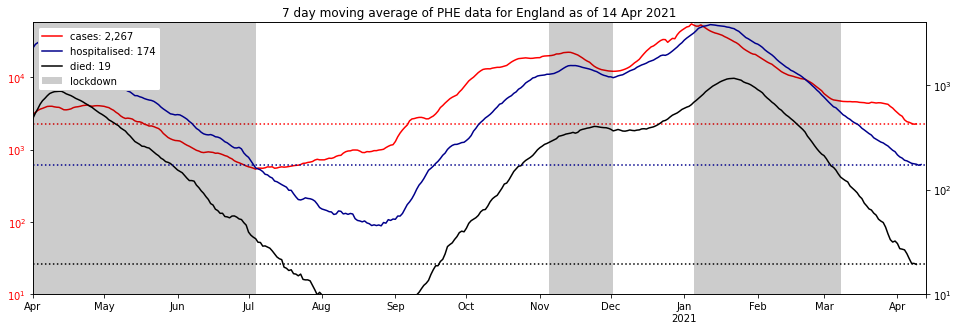

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

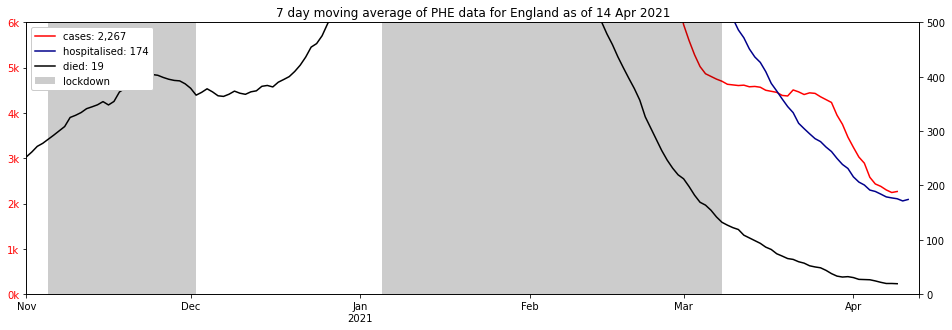

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=6_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

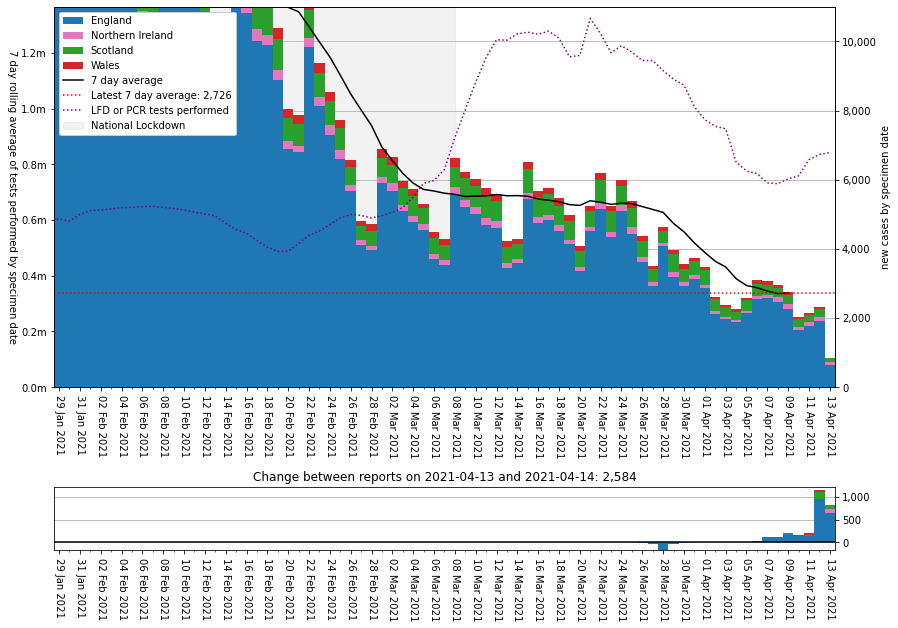

In [5]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

In [6]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,13 Apr 21,"+6,762,337","+27,172,302","+6,762,337","+257,732","+39,361","+257,732"
Northern Ireland,13 Apr 21,"+224,129","+838,049","+224,129","+13,659","+6,154","+13,659"
Scotland,13 Apr 21,"+634,422","+2,694,971","+634,422","+29,296","+12,265","+29,296"
Wales,13 Apr 21,"+549,193","+1,621,282","+549,193","+11,998","+18,343","+11,998"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,6762337.0,27172302.0,20409965.0,56286961,12.014038,36.260556,51.725406
1,Northern Ireland,N92000002,224129.0,838049.0,613920.0,1893667,11.835713,32.419639,55.744648
2,Scotland,S92000003,634422.0,2694971.0,2060549.0,5463300,11.612432,37.716197,50.671371
3,Wales,W92000004,549193.0,1621282.0,1072089.0,3152879,17.418778,34.003493,48.577728


'partial: 32,326,604 (48.4%), full: 8,170,081'

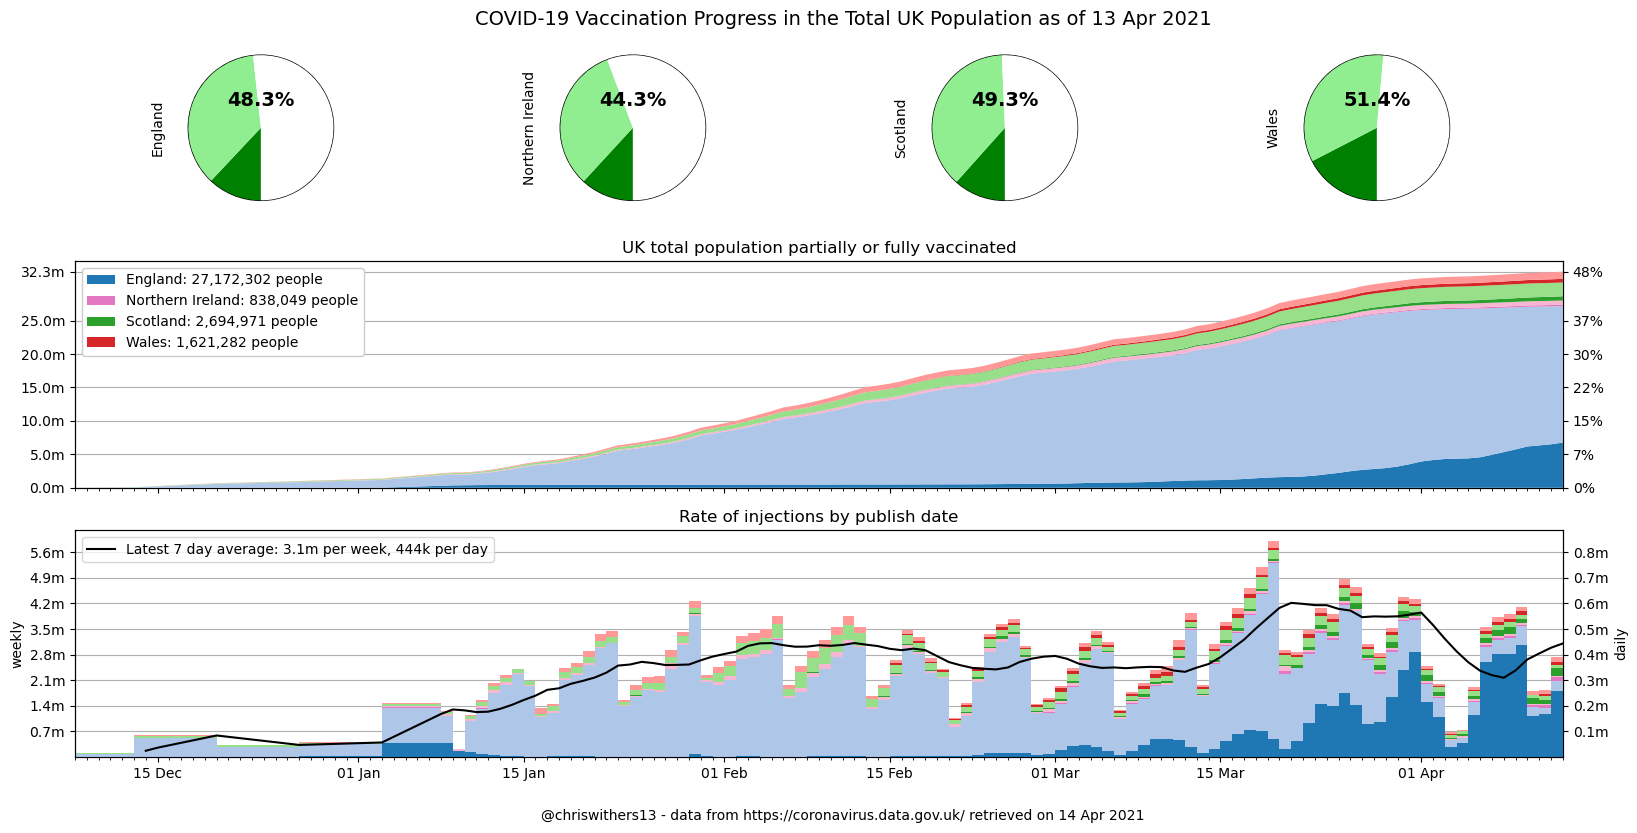

In [7]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

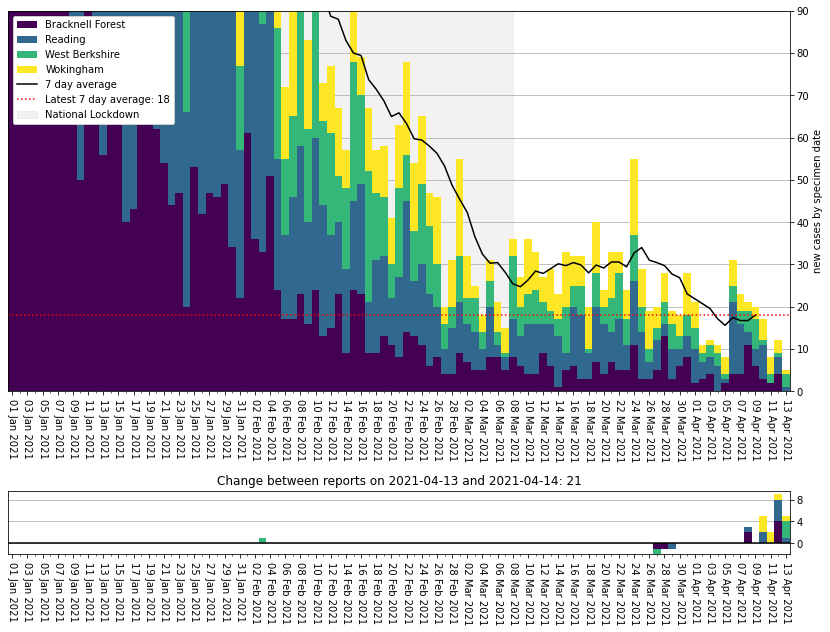

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=90)

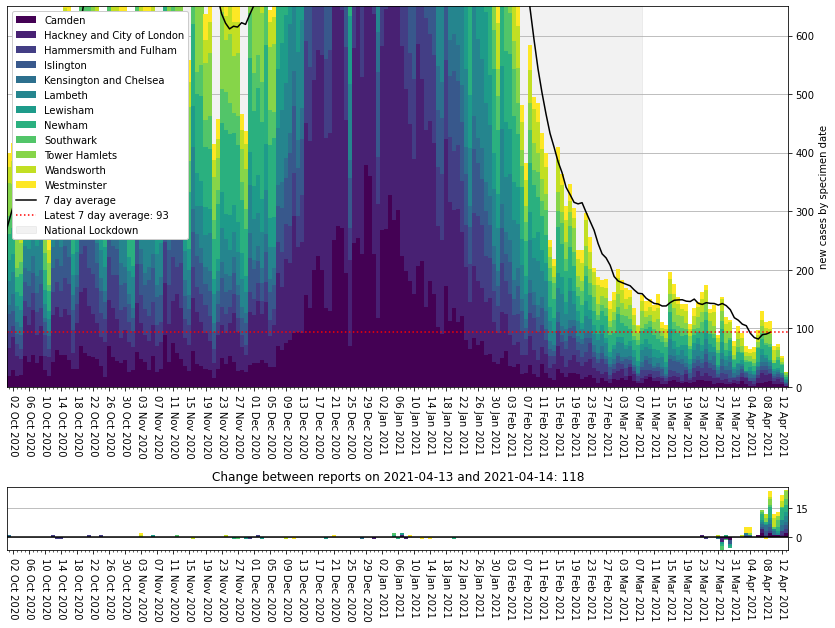

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
N09000005,Derry City and Strabane,101.134290,153.0,2021-04-13
E08000017,Doncaster,76.950207,240.0,2021-04-13
E06000032,Luton,75.568406,161.0,2021-04-13
E08000032,Bradford,74.290076,401.0,2021-04-13
E07000150,Corby,70.619513,51.0,2021-04-13
E08000016,Barnsley,70.078504,173.0,2021-04-13
E08000018,Rotherham,69.326441,184.0,2021-04-13
E08000036,Wakefield,66.319851,231.0,2021-04-13
E06000013,North Lincolnshire,65.005920,112.0,2021-04-13


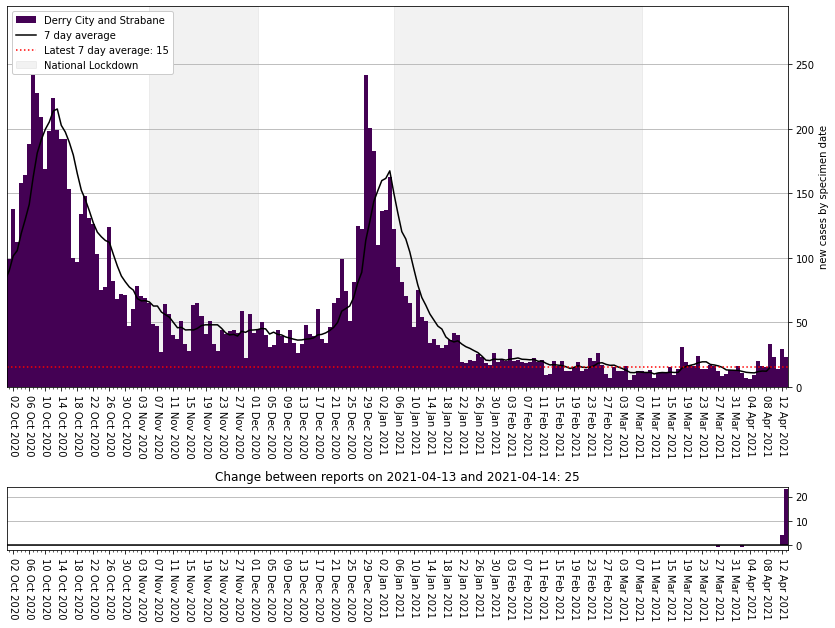

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000032,Bradford,74.290076,401.0,2021-04-13
E08000035,Leeds,46.776164,371.0,2021-04-13
S12000049,Glasgow City,51.017185,323.0,2021-04-13
E08000019,Sheffield,50.781991,297.0,2021-04-13
E08000025,Birmingham,23.996861,274.0,2021-04-13
E08000034,Kirklees,61.620739,271.0,2021-04-13
E08000003,Manchester,47.390107,262.0,2021-04-13
E08000017,Doncaster,76.950207,240.0,2021-04-13
E08000036,Wakefield,66.319851,231.0,2021-04-13


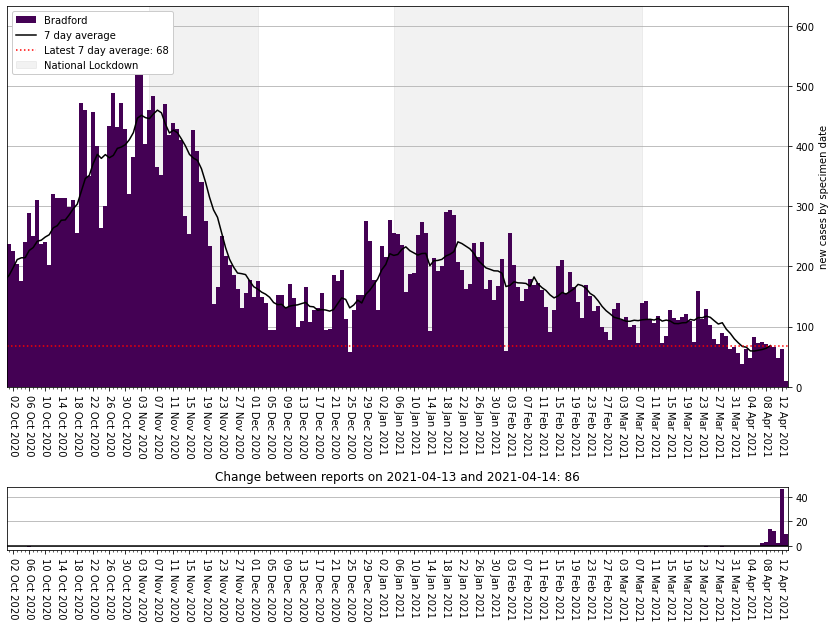

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [15]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.0
phe_max = 0.13

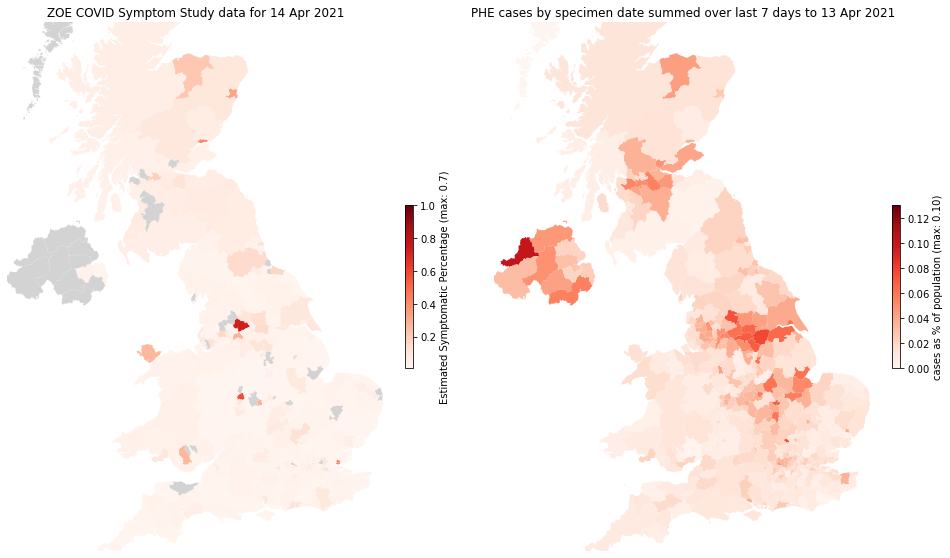

In [16]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [17]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...